In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2

from itertools import product
from scipy.stats import chi2_contingency
import shap

In [2]:
df  =pd.read_csv('onlinedeliverydata.csv')

In [3]:
df.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,...,Less Delivery time,High Quality of package,Number of calls,Politeness,Freshness,Temperature,Good Taste,Good Quantity,Output,Reviews
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,...,Moderately Important,Moderately Important,Moderately Important,Moderately Important,Moderately Important,Moderately Important,Moderately Important,Moderately Important,Yes,Nil\n
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,...,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Yes,Nil
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,...,Important,Very Important,Moderately Important,Very Important,Very Important,Important,Very Important,Moderately Important,Yes,"Many a times payment gateways are an issue, so..."
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,...,Very Important,Important,Moderately Important,Very Important,Very Important,Very Important,Very Important,Important,Yes,nil
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,...,Important,Important,Moderately Important,Important,Important,Important,Very Important,Very Important,Yes,NIL


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 55 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Age                                        388 non-null    int64  
 1   Gender                                     388 non-null    object 
 2   Marital Status                             388 non-null    object 
 3   Occupation                                 388 non-null    object 
 4   Monthly Income                             388 non-null    object 
 5   Educational Qualifications                 388 non-null    object 
 6   Family size                                388 non-null    int64  
 7   latitude                                   388 non-null    float64
 8   longitude                                  388 non-null    float64
 9   Pin code                                   388 non-null    int64  
 10  Medium (P1)               

In [5]:
df.shape

(388, 55)

In [6]:
df.describe()

,Age,Family size,latitude,longitude,Pin code
count,388.000000,388.000000,388.000000,388.000000,388.000000
mean,24.628866,3.280928,12.972058,77.600160,560040.113402
std,2.975593,1.351025,0.044489,0.051354,31.399609
min,18.000000,1.000000,12.865200,77.484200,560001.000000
25%,23.000000,2.000000,12.936900,77.565275,560010.750000
50%,24.000000,3.000000,12.977000,77.592100,560033.500000
75%,26.000000,4.000000,12.997025,77.630900,560068.000000
max,33.000000,6.000000,13.102000,77.758200,560109.000000


In [7]:
df.isnull().sum().any()

False

In [8]:
# Group the column based on the question
influence = ['Ease and convenient','Time saving', 'More restaurant choices', 'Easy Payment option',
       'More Offers and Discount', 'Good Food quality', 'Good Tracking system'] 

not_purchase = ['Self Cooking', 'Health Concern', 'Late Delivery', 'Poor Hygiene',
       'Bad past experience', 'Unavailability', 'Unaffordable']

cancelation = ['Long delivery time', 'Delay of delivery person getting assigned',
       'Delay of delivery person picking up food', 'Wrong order delivered',
       'Missing item', 'Order placed by mistake']

delivery = ['Influence of time',
       'Order Time', 'Maximum wait time', 'Residence in busy location',
       'Google Maps Accuracy', 'Good Road Condition', 'Low quantity low time',
       'Delivery person ability', 'Less Delivery time', 'Number of calls', 'Politeness']

food = ['High Quality of package', 'Freshness ', 'Temperature', 'Good Taste ', 'Good Quantity']

In [9]:
for i in df.columns:
    try:
        df[i] = df[i].str.lower()
    except:
        pass

In [10]:
# Replace the string value to number
df = df.replace(['no income', 'below rs.10000', '10001 to 25000', '25001 to 50000', 'more than 50000'], ['0', '<10k', '10k-25k', '25k-50k', '>50k'])
df = df.replace(['yes', 'no', 'maybe'], [1, 0, 2])
df = df.replace(['strongly disagree', 'disagree', 'neutral', 'agree', 'strongly agree'], [1,2,3,4,5])
df = df.replace(['unimportant', 'slightly important','important', 'moderately important', 'very important'], [1,2,3,4,5])

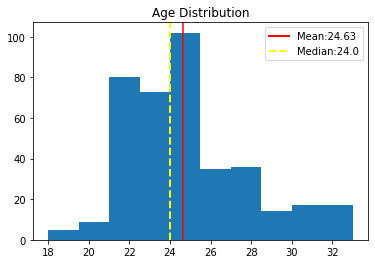

In [11]:
plt.hist(df['Age'])
plt.axvline(x=df['Age'].mean(),color='red')
plt.axvline(x=df['Age'].median(),color='yellow',ls='--', lw=2)

custom_lines = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='yellow', lw=2, ls='--')]
plt.legend(custom_lines, [f"Mean:{round(df['Age'].mean(),2)}", f"Median:{round(df['Age'].median(),2)}"])
plt.title('Age Distribution')
plt.show()

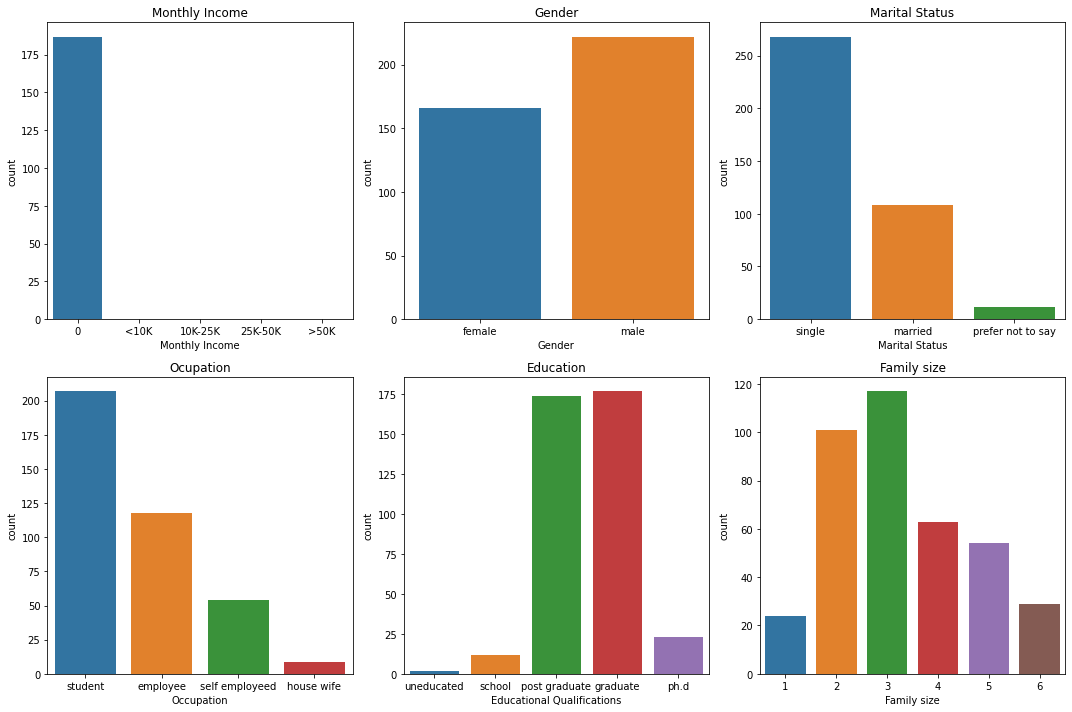

In [12]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
sns.countplot(data=df, x='Monthly Income', ax=ax[0][0], order=['0', '<10K', '10K-25K', '25K-50K', '>50K'])
ax[0][0].set_title('Monthly Income')
sns.countplot(data=df, x='Gender', ax=ax[0][1])
ax[0][1].set_title('Gender')
sns.countplot(data=df, x='Marital Status', ax=ax[0][2])
ax[0][2].set_title('Marital Status')
sns.countplot(data=df, x='Occupation', ax=ax[1][0])
ax[1][0].set_title('Ocupation')
sns.countplot(data=df, x='Educational Qualifications', ax=ax[1][1], order=['uneducated', 'school', 'post graduate', 'graduate', 'ph.d'])
ax[1][1].set_title('Education')
sns.countplot(data=df, x='Family size', ax=ax[1][2])
ax[1][2].set_title('Family size')
plt.tight_layout()
plt.show()

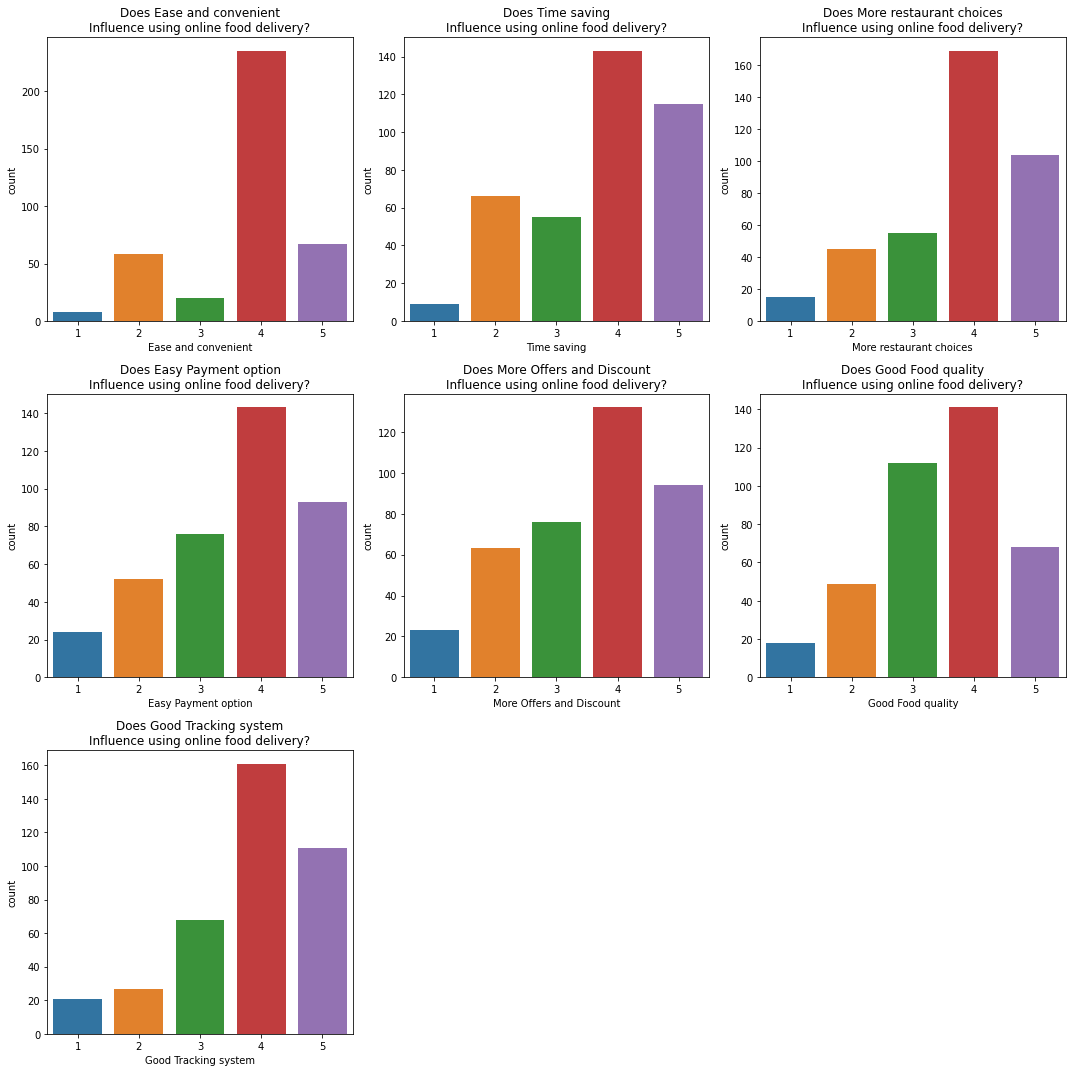

In [13]:
#What Features Influence Respondents Using Online Food Delivery?
plt.figure(figsize=(15,15))
for i, column in enumerate(influence):
    plt.subplot(3, 3, i+1)
    sns.countplot(data=df, x=column)
    plt.title(f'Does {column}\nInfluence using online food delivery?')
    plt.tight_layout()

# What Conditions Keep Respondents From Using Online Food Delivery?

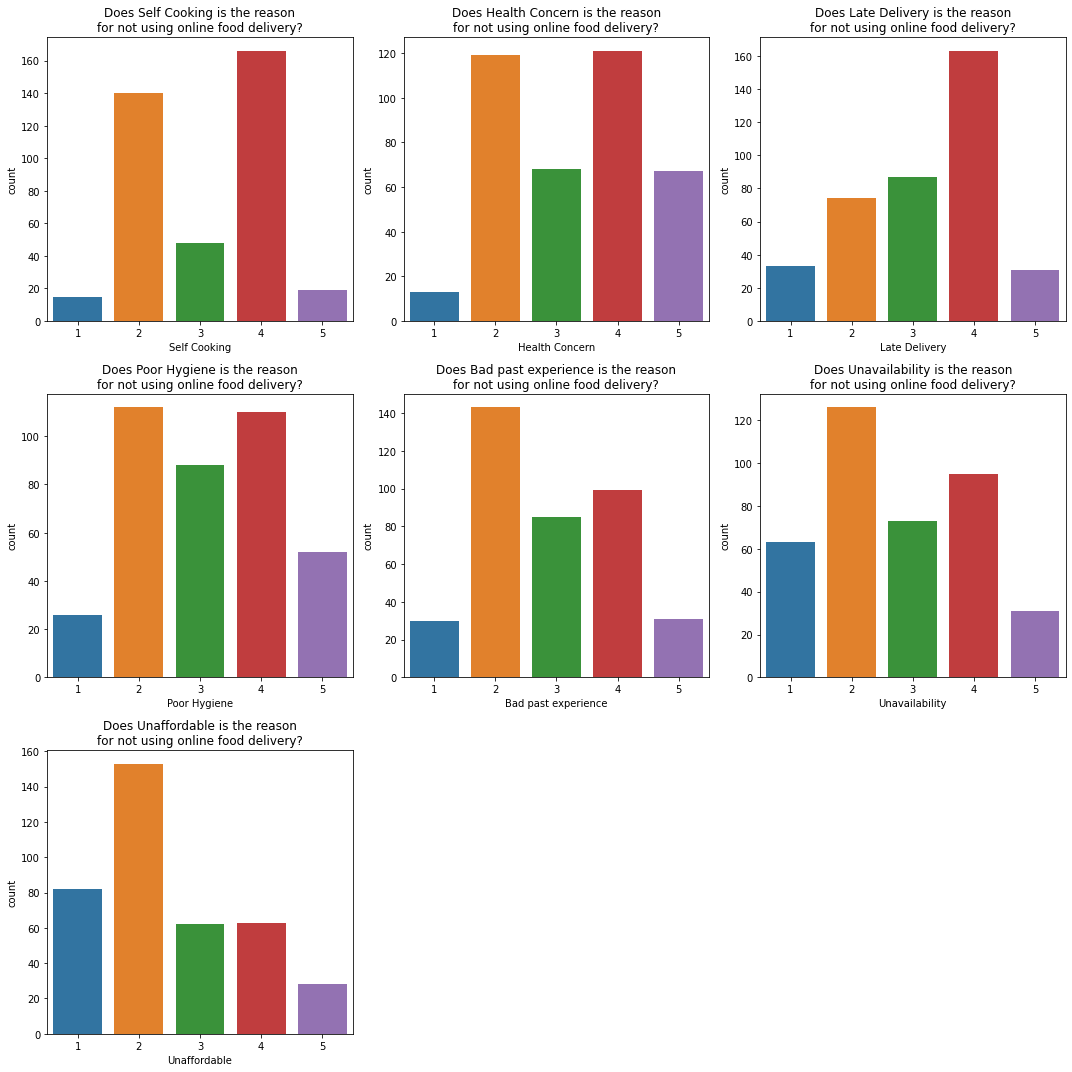

In [14]:
plt.figure(figsize=(15,15))
for i, column in enumerate(not_purchase):
    plt.subplot(3, 3, i+1)
    sns.countplot(data=df, x=column)
    plt.title(f'Does {column} is the reason\nfor not using online food delivery?')
    plt.tight_layout()

# What Event Make Respondents Cancel the Online Food Delivery?

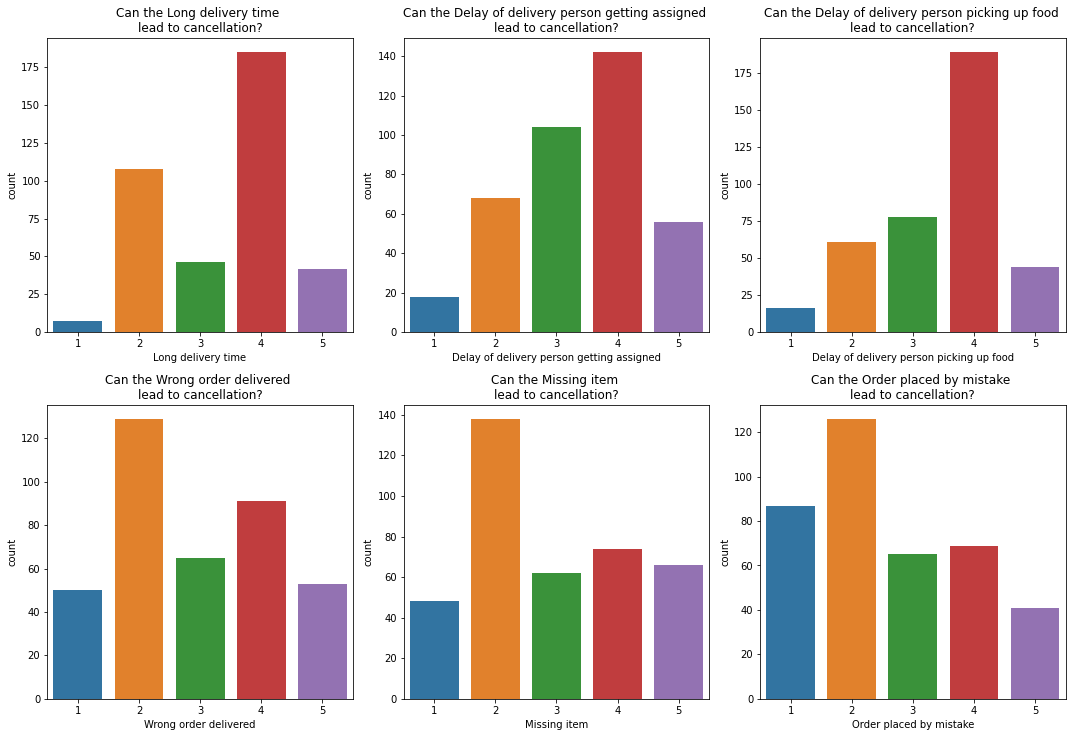

In [15]:
plt.figure(figsize=(15,15))
for i, column in enumerate(cancelation):
    plt.subplot(3, 3, i+1)
    sns.countplot(data=df, x=column)
    plt.title(f'Can the {column} \nlead to cancellation?')
    plt.tight_layout()

# Is This Food-Related Thing Important?

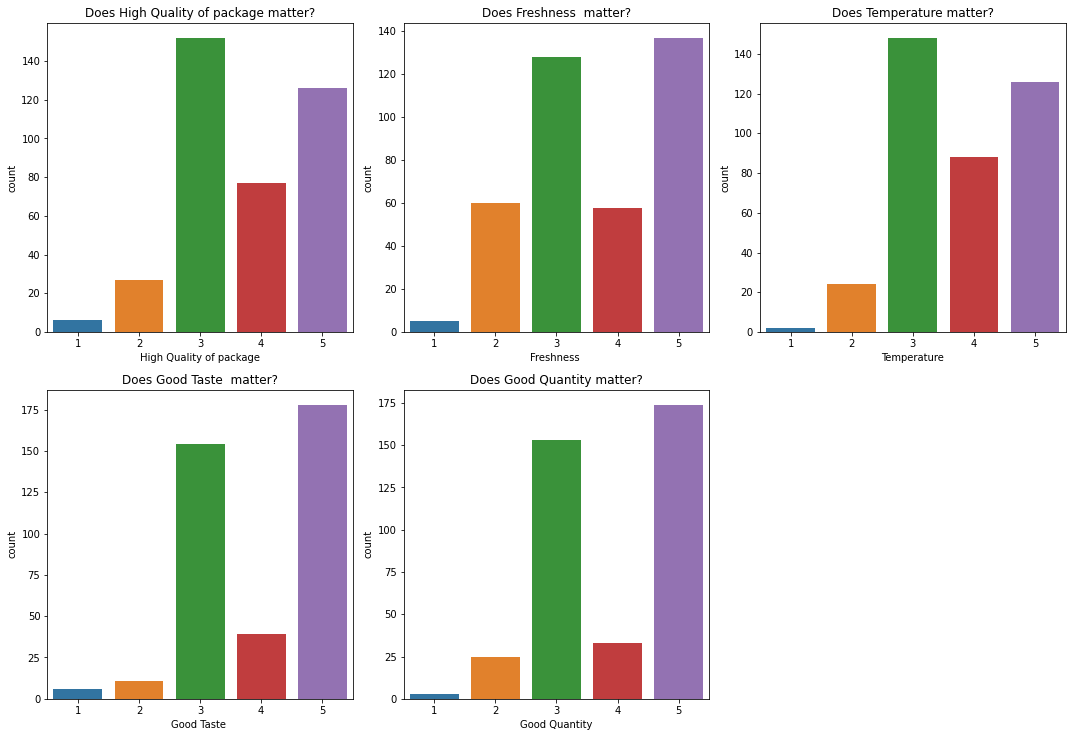

In [16]:
plt.figure(figsize=(15,15))
for i, column in enumerate(food):
    plt.subplot(3, 3, i+1)
    sns.countplot(data=df, x=column)
    plt.title(f'Does {column} matter?')
    plt.tight_layout()

# The Number Of Respondents Who Will Use Online Food Delivery Again

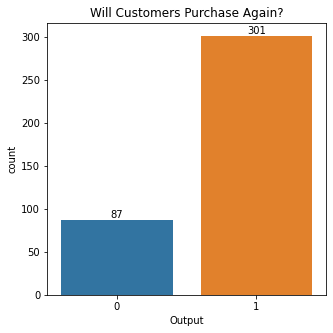

In [17]:
fig, ax  = plt.subplots(figsize=(5,5))
ax = sns.countplot(data=df, x='Output')
ax.set_xticklabels(ax.get_xticklabels())
ax.bar_label(ax.containers[0])
plt.title('Will Customers Purchase Again?')
plt.show()

#From the graph, we know that 87(22%) respondents will not purchase again and it's quite high

In [18]:
import matplotlib 
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.6.1


In [19]:
# Change some features value to number, so we can plot it
df = df.replace(['0', '<10k', '10k-25k', '25k-50k', '>50k'], [1,2,3,4,5])
df = df.replace(['15 minutes', '30 minutes', '45 minutes', '60 minutes', 'more than 60 minutes'], [1,2,3,4,5])
trans_col = ['Gender', 'Marital Status', 'Occupation','Educational Qualifications','Medium (P1)', 
             'Medium (P2)', 'Meal(P1)', 'Meal(P2)', 'Perference(P1)', 'Perference(P2)']
for col in trans_col:
    df[col] = LabelEncoder().fit_transform(df[col])

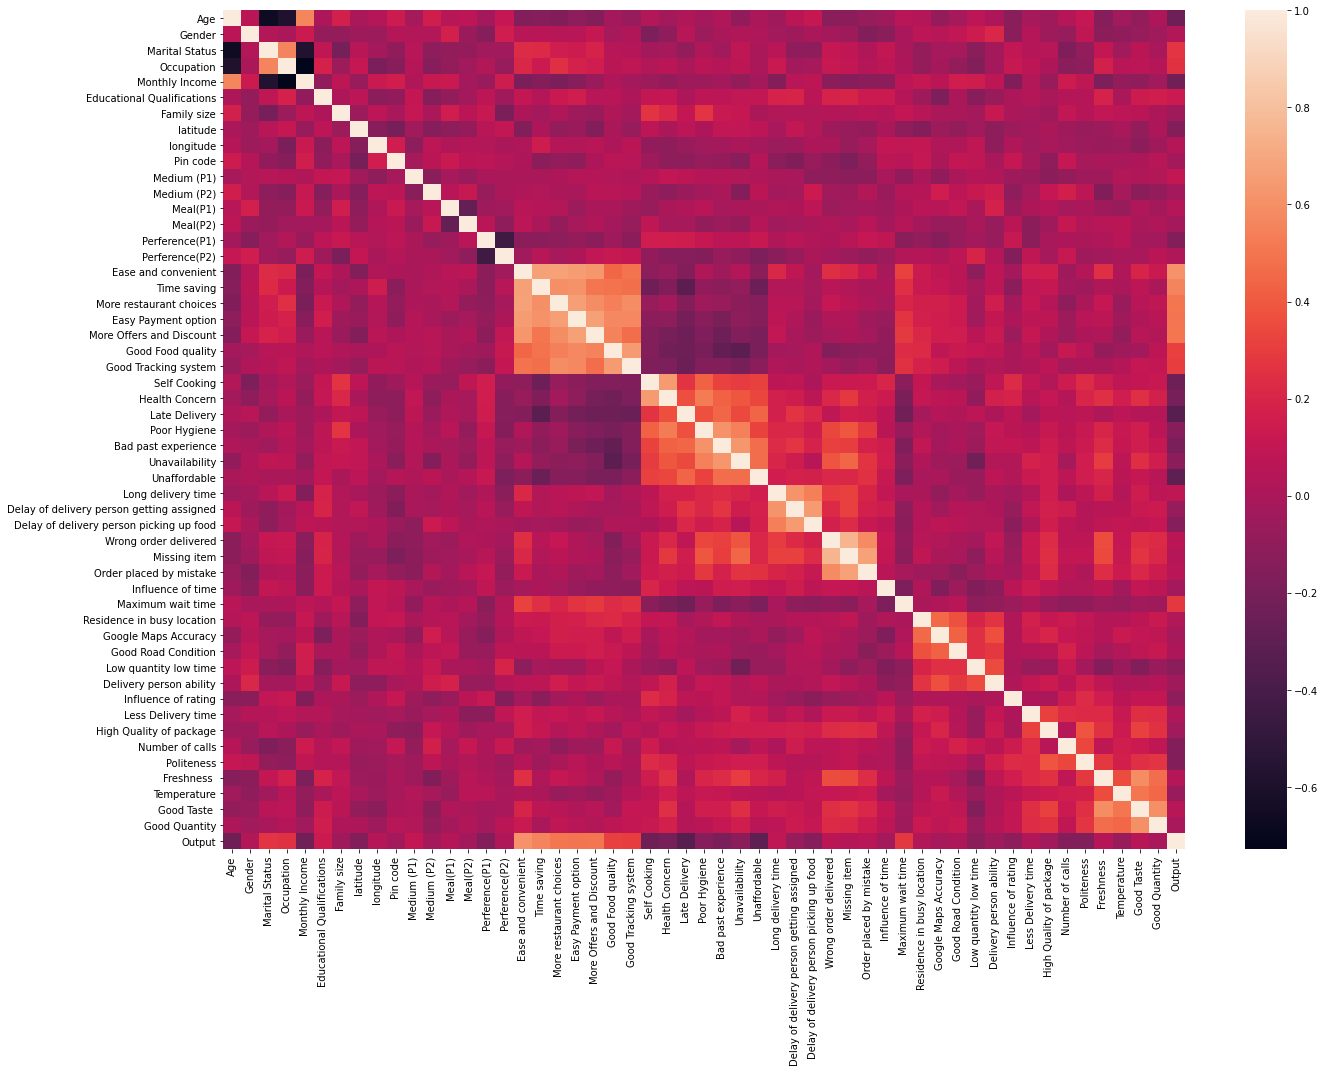

In [20]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr('pearson'))
plt.tight_layout()

# What Features Influence Customers To Use Online Food Delivery?

In [21]:
RFC = RandomForestClassifier(n_estimators=500)

x = df.drop(columns=['Output', 'Reviews', 'Order Time','latitude','longitude'])
y = df['Output']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y) 

RFC.fit(X_train, y_train)

y_pred=RFC.predict(X_test)

In [22]:
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred), '\n')
print('Accuracy Score:\n', accuracy_score(y_test, y_pred), '\n')
print('Classification Report:\n', classification_report(y_test, y_pred))

Confusion Matrix:
 [[12  5]
 [ 1 60]] 

Accuracy Score:
 0.9230769230769231 

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.71      0.80        17
           1       0.92      0.98      0.95        61

    accuracy                           0.92        78
   macro avg       0.92      0.84      0.88        78
weighted avg       0.92      0.92      0.92        78



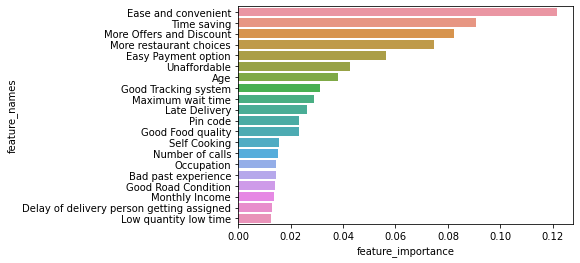

In [23]:
feature_importance = np.array(RFC.feature_importances_)
feature_names = np.array(x.columns)

#Create a DataFrame using a Dictionary
data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
sns.barplot(data=fi_df[:20], y='feature_names', x='feature_importance')
plt.show()